In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from reconstruction import Model, TopKLayer
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import synthesizer
from torch import optim

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
m = Model('./lisa.webp', device=device)

fc2a0ff5de385fb8388641819ac8647d


In [30]:
I = torch.rand((1, 3, m.dimensions[0], m.dimensions[1])).to(device)
I = I.requires_grad_(True)
optimizer = optim.LBFGS([I], lr=1)

In [31]:
epochs = 100
r = 0
while r < epochs:
    def closure():
        optimizer.zero_grad()
        I.grad = None
        m(I)
        loss = m.loss()
        loss.backward(retain_graph=True)
        #print(f'I gradient: {I.grad}')
        return loss
    optimizer.step(closure)

    r += 1
    print(f'\rRun {r}: Loss {m.loss().item()}', end='')

print()

Run 100: Loss 166433.68755


In [14]:
torch.save(m.topkLayers[5].targetActivations, 'topk6')

IndexError: list index out of range

In [15]:
k = torch.load('topk1')

In [8]:
m.model[0:3]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): TopK(0.2)
)

In [8]:
layers = [m.model[0], m.model[1], m.model[2]]

def fw(x):
    #for l in layers:
    #    x = l(x)
    return m.model(x)

def loss(x):
    return (x - c_target).sum()

In [9]:
I = transforms.ToTensor()(Image.open("./fish.jpg").resize([500, 500])).unsqueeze(0).to(device)

In [10]:
c_target = fw(I)

In [11]:
torch.manual_seed(0)
I = torch.rand((1, 3, m.dimensions[0], m.dimensions[1])).to(device)

In [12]:
I = I.requires_grad_(True)
I.grad = None

c = fw(I)
l = loss(c)
print(l)
l.backward()

with torch.no_grad():
    I.data -= I.grad
    I.grad.zero_() 

c = fw(I)
l = loss(c)
print(l)

tensor(-1518.0234, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-1820.5020, device='cuda:0', grad_fn=<SumBackward0>)


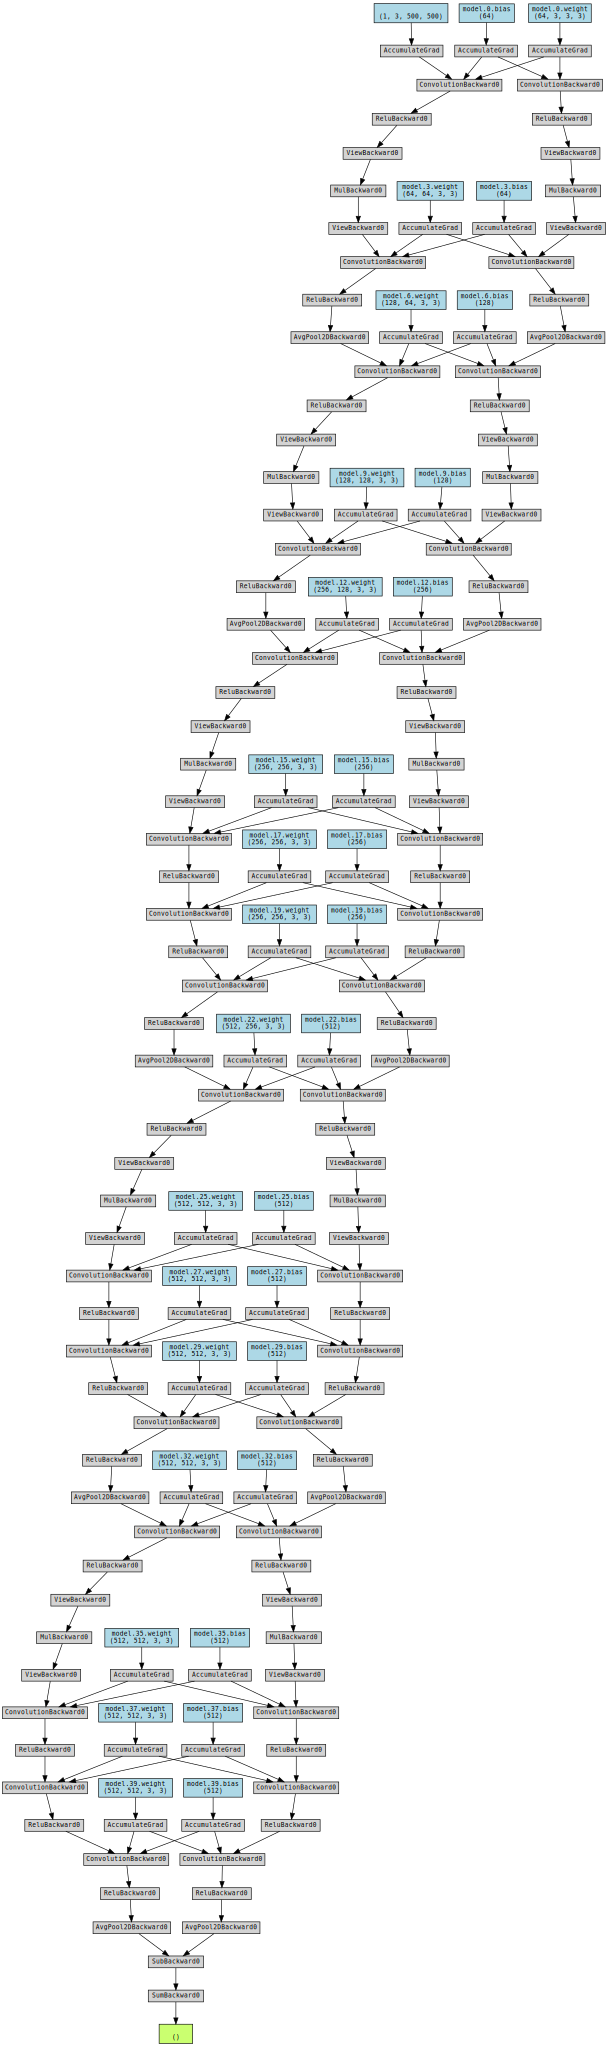

In [13]:
import torchviz 	graph [size="41.699999999999996,41.699999999999996"]
torchviz.make_dot(l, params=dict(m.named_parameters()))

In [41]:
x_ = torch.zeros((1, 4, 6, 6))
x_[0][0][0] = torch.tensor([1, 0.2, 0.4, 0.7, 0.5, 0.3])
x_[0][0][1] = torch.tensor([0.3, 0.2, 0.4, 0.7, 0.5, 0.1])
x_[0][0][2] = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.3, 1])
x = x_.clone().detach().requires_grad_(True)

topk = TopKLayer(device='cpu')
#def topk(x, k=0.2):
#    n, c, h, w = x.shape
#    topk_keep_num = max(1, int(k * h * w))
#    
#    x_reshape = x.view(n, c, h * w)
#    _, index = torch.topk(x_reshape.abs(), topk_keep_num, dim=2)
#    mask = torch.zeros_like(x_reshape).scatter_(2, index, 1)
#    sparse_x = mask * x_reshape
#    out = sparse_x.view(n, c, h, w)
#    return x

def loss(x):
    return (x ** 2).sum()

output = topk(x)
l = loss(output)
l.backward()
print(l)
print(x.grad[0][0])

x.data -= 0.8 * x.grad
x.grad = None

output = topk(x)
l = loss(output)
l.backward()
print(l)
print(x.grad[0][0])

tensor(3.6400, grad_fn=<SumBackward0>)
tensor([[2.0000, 0.0000, 0.0000, 1.4000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.8000, 1.4000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
tensor(1.4128, grad_fn=<SumBackward0>)
tensor([[-1.2000,  0.0000,  0.8000, -0.8400, -0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000, -0.8400, -0.6000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.6000, -1.2000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


tensor(23.0400, device='cuda:0', grad_fn=<PowBackward0>)

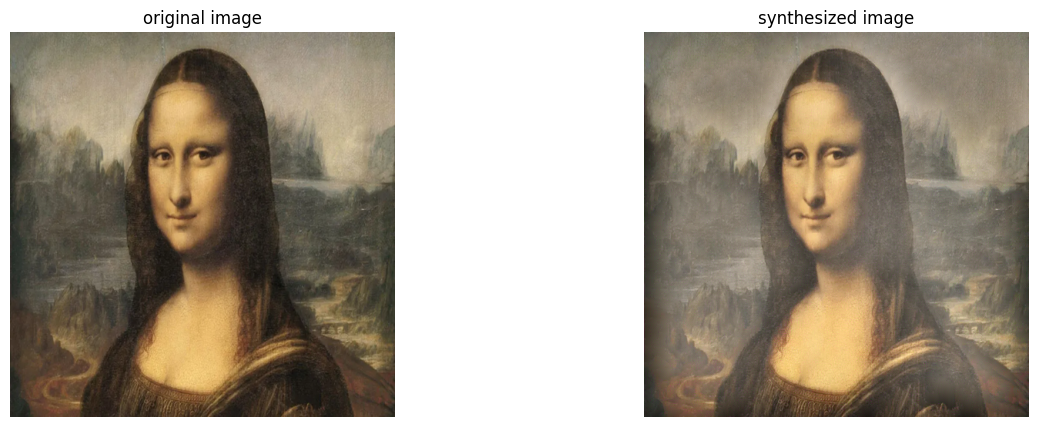

In [32]:
img = np.clip(I.clone().detach().cpu().squeeze(0).numpy().transpose(1, 2, 0), 0, 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(Image.open('./lisa.webp').resize(m.dimensions))
ax1.axis('off')
ax1.set_title('original image')
ax2.imshow(img)
ax2.axis('off')
ax2.set_title('synthesized image')
plt.savefig('oh-man.png')
plt.show()